<a href="https://colab.research.google.com/github/jeffheaton/stylegan2-toys/blob/master/morph_video_real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Jeff Heaton](https://raw.githubusercontent.com/jeffheaton/present/master/images/github.jpg)

Copyright 2021 by [Jeff Heaton](https://www.youtube.com/channel/UCR1-GEpyOPzT2AO4D_eifdw), [released under Apache 2.0 license](https://github.com/jeffheaton/present/blob/master/LICENSE)
# StyleGAN2 Morph Between Two REAL Images

This notebook allows you to choose a starting and ending image and use StyleGAN2 to produce a "morph" video between the two pictures.  For the morph to work correctly, both images should be of human faces.  It helps if both pictures are cropped reasonably well to a square portrait to eliminate the possibility of two faces being present in one image.  The preprocessing code will lock in on the exact positioning of each image, so your crop does not have to be perfect. The main point of your crop is for you to remove anything else that might be confused for a face.  If multiple faces are detected, you will receive an error.

Also, make sure you have selected a GPU Runtime from CoLab. Choose "Runtime," then "Change Runtime Type," and choose GPU for "Hardware Accelerator."

The following YouTube video describes precisely how to run this notebook.

[Morphing Real Images to Video with StyleGAN2 ADA](http://youtube.com)

These settings allow you to change the high-level configuration.  The number of steps determines how long your resulting video is.  The video plays at 30 frames a second, so 150 is 5 seconds. You can also specify freeze steps to leave the video unchanged at the beginning and end. You will not likely need to change the network.


In [ ]:
face_NETWORK = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
NETWORK = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqcat.pkl"
STEPS = 150
FPS = 30
FREEZE_STEPS = 30

# Upload Starting Image

Choose your starting image.

In [ ]:
import os
from google.colab import files

uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for source.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    SOURCE_NAME = f"source{ext}"
    open(SOURCE_NAME, 'wb').write(v)

Saving human_aligned.jpg to human_aligned.jpg


Also, choose your ending image.

In [ ]:
uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for target.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    TARGET_NAME = f"target{ext}"
    open(TARGET_NAME, 'wb').write(v)

Saving cat_best_LL.jpg to cat_best_LL.jpg


# Install Software

Some software must be installed into Colab, for this notebook to work. We are specificially using these technologies:

* [Training Generative Adversarial Networks with Limited Data](https://arxiv.org/abs/2006.06676)
Tero Karras, Miika Aittala, Janne Hellsten, Samuli Laine, Jaakko Lehtinen, Timo Aila
* [One millisecond face alignment with an ensemble of regression trees](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf) Vahid Kazemi, Josephine Sullivan


In [ ]:
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_5_face_landmarks.dat.bz2

--2021-12-24 05:50:24--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2’

shape_predictor_5_f 100%[===================>]   5.44M  28.3MB/s    in 0.2s    

2021-12-24 05:50:25 (28.3 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2’ saved [5706710/5706710]



In [1]:
import sys
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
sys.path.insert(0, "/content/stylegan2-ada-pytorch")

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 1.12 MiB | 32.78 MiB/s, done.
Resolving deltas: 100% (58/58), done.
     |████████████████████████████████| 108 kB 7.3 MB/s 


# Preprocess Images for Best StyleGAN Results

The following are helper functions for the preprocessing.

In [ ]:
import cv2
import numpy as np
from PIL import Image
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

def find_eyes(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 0)
  
  if len(rects) == 0:
    raise ValueError("No faces detected")
  elif len(rects) > 1:
    raise ValueError("Multiple faces detected")

  shape = predictor(gray, rects[0])
  features = []

  for i in range(0, 5):
    features.append((i, (shape.part(i).x, shape.part(i).y)))

  return (int(features[3][1][0] + features[2][1][0]) // 2, \
    int(features[3][1][1] + features[2][1][1]) // 2), \
    (int(features[1][1][0] + features[0][1][0]) // 2, \
    int(features[1][1][1] + features[0][1][1]) // 2)

def crop_stylegan(img):
  left_eye, right_eye = find_eyes(img)
  d = abs(right_eye[0] - left_eye[0])
  z = 255/d
  ar = img.shape[0]/img.shape[1]
  w = img.shape[1] * z
  img2 = cv2.resize(img, (int(w), int(w*ar)))
  bordersize = 1024
  img3 = cv2.copyMakeBorder(
      img2,
      top=bordersize,
      bottom=bordersize,
      left=bordersize,
      right=bordersize,
      borderType=cv2.BORDER_REPLICATE)

  left_eye2, right_eye2 = find_eyes(img3)

  crop1 = left_eye2[0] - 385 
  crop0 = left_eye2[1] - 490
  return img3[crop0:crop0+1024,crop1:crop1+1024]

The following will preprocess and crop your images.  If you receive an error indicating multiple faces were found, try to crop your image better or obscure the background.  If the program does not see a face, then attempt to obtain a clearer and more high-resolution image.

In [ ]:
print(SOURCE_NAME, TARGET_NAME)

source.jpg target.jpg


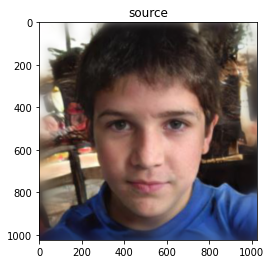

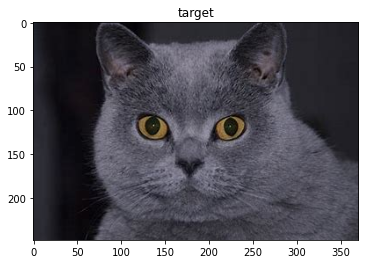

True

In [ ]:
from matplotlib import pyplot as plt
import cv2

image_source = cv2.imread(SOURCE_NAME)
if image_source is None:
    raise ValueError("Source image not found")

image_target = cv2.imread(TARGET_NAME)
if image_target is None:
    raise ValueError("Source image not found")


cropped_source = crop_stylegan(image_source)
# cropped_target = crop_stylegan(image_target)
cropped_target = image_target

img = cv2.cvtColor(cropped_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

img = cv2.cvtColor(cropped_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target')
plt.show()

cv2.imwrite("cropped_source.png", cropped_source)
cv2.imwrite("cropped_target.png", cropped_target)

#print(find_eyes(cropped_source))
#print(find_eyes(cropped_target))

In [ ]:
# Avoid the aligning from the above face detector.
# We can do manual aligning and center cropping, but I think the cat image is already
# pretty centered, so I simply resized. If you find fault with
# your cat image, add some preprocessing here!

img = Image.open('cropped_target.png')
img = img.resize((1024, 1024))
img.save('cropped_target.png')

# Convert Source to a GAN

First, we convert the source to a GAN latent vector.  This process will take several minutes.

In [ ]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_source --target=cropped_source.png --network={face_NETWORK}"
!{cmd}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/1000: dist 0.62 loss 24567.17
step    2/1000: dist 0.57 loss 27640.47
step    3/1000: dist 0.58 loss 27166.95
step    4/1000: dist 0.58 loss 26253.08
step    5/1000: dist 0.59 loss 24956.89
step    6/1000: dist 0.60 loss 23353.74
step    7/1000: dist 0.62 loss 21512.52
step    8/1000: dist 0.56 loss 19485.86
step    9/1000: dist 0.62 loss 17339.20
step   10/1000: dist 0.57 loss 15139.44
step   11/1000: dist 0.55 loss 12948.96
step   12/1000: dist 0.64 loss 10818.45
step   13/1000: dist 0.58 loss 8801.99
step   14/1000: dist 0.55 loss 6945.90
step   15/1000: dist 0.56 loss 5315.22
step   16/1000: dist 0.57 loss 3970.87
step   17/1000: dist 0.55 loss 2943.98
step   18/1000: dist 0.55 loss 2215.11
step   19/1000: dist 0

# Convert Target to a GAN

Next, we convert the target to a GAN latent vector.  This process will also take several minutes.

In [ ]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_target --target=cropped_target.png --network={NETWORK}"
!{cmd}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqcat.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/1000: dist 0.60 loss 24566.36
step    2/1000: dist 0.63 loss 27639.75
step    3/1000: dist 0.65 loss 27166.90
step    4/1000: dist 0.64 loss 26251.34
step    5/1000: dist 0.58 loss 24955.40
step    6/1000: dist 0.63 loss 23353.00
step    7/1000: dist 0.59 loss 21511.21
step    8/1000: dist 0.63 loss 19484.66
step    9/1000: dist 0.57 loss 17338.62
step   10/1000: dist 0.57 loss 15137.80
step   11/1000: dist 0.56 loss 12948.33
step   12/1000: dist 0.57 loss 10817.59
step   13/1000: dist 0.57 loss 8800.51
step   14/1000: dist 0.55 loss 6945.34
step   15/1000: dist 0.59 loss 5313.95
step   16/1000: dist 0.59 loss 3969.27
step   17/1000: dist 0.55 loss 2941.61
step   18/1000: dist 0.55 loss 2214.50
step   19/1000: dis

With the conversion complete, lets have a look at the two GANs.

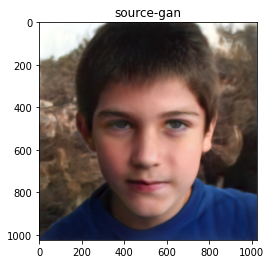

In [ ]:
img_gan_source = cv2.imread('/content/out_source/proj.png')
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source-gan')
plt.show()

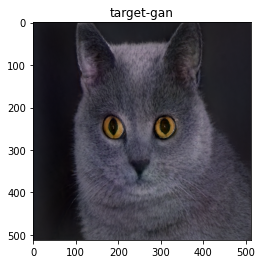

In [ ]:
img_gan_target = cv2.imread('/content/out_target/proj.png')
img = cv2.cvtColor(img_gan_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target-gan')
plt.show()

# Build the Video

The following code builds a transition video between the two latent vectors previously obtained.

In [ ]:
lvec1 = np.load('/content/out_source/projected_w.npz')['w'][:, 2:, :]
lvec2 = np.load('/content/out_target/projected_w.npz')['w']

print(lvec1.shape, lvec2.shape)

(1, 16, 512) (1, 16, 512)


In [ ]:
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm

lvec1 = np.load('/content/out_source/projected_w.npz')['w'][:, :16, :]
lvec2 = np.load('/content/out_target/projected_w.npz')['w']

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqcat.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer('/content/movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for j in tqdm(range(STEPS)):
  z = torch.from_numpy(current).to(device)
  synth_image = G.synthesis(z, noise_mode='const')
  synth_image = (synth_image + 1) * (255/2)
  synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

  repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1
   
  for i in range(repeat):
    video.append_data(synth_image)
  current = current + step


video.close()

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
lvec1.shape, lvec2.shape

((1, 16, 512), (1, 16, 512))

# Download your Video

If you made it through all of these steps, you are now ready to download your video.

In [ ]:
from google.colab import files
files.download("movie.mp4") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Exploring Some Python Files

*First off, what is projector.py?*

We know at a high-level, this basically takes an input image and the network model tries to find the best latent vector to represent it.

```py
@click.option('--network', 'network_pkl', help='Network pickle filename', required=True)
@click.option('--target', 'target_fname', help='Target image file to project to', required=True, metavar='FILE')
@click.option('--num-steps',              help='Number of optimization steps', type=int, default=1000, show_default=True)
@click.option('--seed',                   help='Random seed', type=int, default=303, show_default=True)
@click.option('--save-video',             help='Save an mp4 video of optimization progress', type=bool, default=True, show_default=True)
@click.option('--outdir',                 help='Where to save the output images', required=True, metavar='DIR')
```

Well, that about sums up the parameters! Looking through a bit of the code, it does, indeed, look like they are optimizing a latent vector.

Well, that's great. We understand this projector.py file on a high level and how to use it. *Now how does the "Build the Video" section work?*

From a 2nd longer look, it looks like it's taking the difference between the 2 vectors and dividing it into intervals. Each interval mark is a new image. At each interval, the synthesis network will predict an image. These images are all put into an mp4.